In [1]:
import pandas as pd
from pandas_datareader import data as pdr

In [2]:
retail = pdr.DataReader('RSAFS', 'fred', '1992-01-01').squeeze().to_frame('retail')

In [3]:
cpi = pdr.DataReader('CPIAUCSL', 'fred', '1992-01-01').squeeze().to_frame('cpi')

In [17]:
df = retail.join(cpi, how='inner')

In [18]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01',
               '2025-11-01', '2025-12-01'],
              dtype='datetime64[ns]', name='DATE', length=408, freq=None)

In [14]:
df.head()

,retail,cpi
DATE,,
1992-01-01,159177,138.3
1992-02-01,159189,138.6
1992-03-01,158647,139.1
1992-04-01,159921,139.4
1992-05-01,160471,139.7


In [15]:
df.tail()

,retail,cpi
DATE,,
2025-08-01,731700,323.291
2025-09-01,732192,324.245
2025-10-01,731051,NaN
2025-11-01,735085,325.063
2025-12-01,734967,326.031


In [16]:
df.shape

(408, 2)

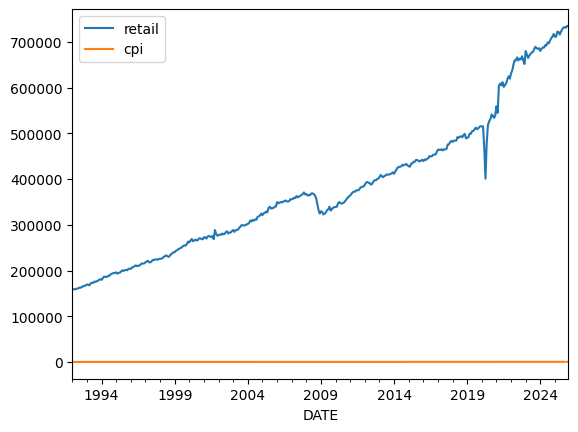

In [6]:
import matplotlib.pyplot as plt

df.plot()
plt.show()

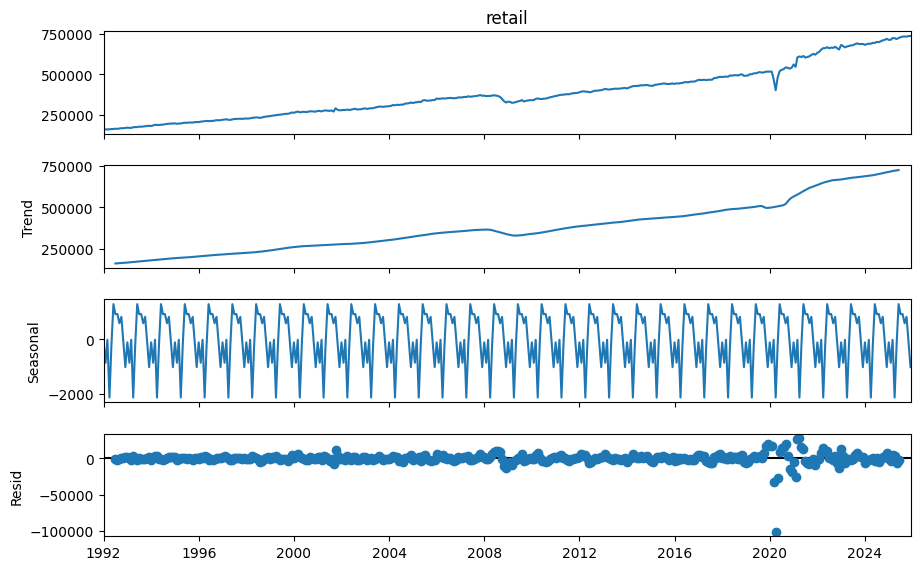

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['retail'], model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10,6)
plt.show()

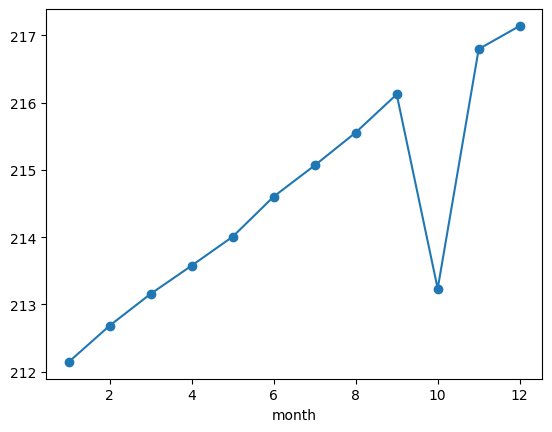

In [19]:
df['month'] = df.index.month
#df.groupby('month')['retail'].mean().plot(marker='o')
df.groupby('month')['cpi'].mean().plot(marker='o')
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['retail'])

print(f'test stats: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
    print(f'Critical value {key}: {value}')

test stats: 1.5486353720742208
p-value: 0.9976949955291013
Critical value 1%: -3.4469717056192213
Critical value 5%: -2.868866381945153
Critical value 10%: -2.570672761197837


## Hyposthesis testing

Null Hypothesis: There is no stationarity in the data
Alternate Hypothesis: There is stationarity in the data


### adfuller (unit root)
test statistic
p-value > 0.05: you fail to reject the null hypothesis (accept it)
p-value < 0.05: you reject the null hypothesis

In [23]:
df['retail'].diff().dropna().head()

DATE
1992-02-01      12.0
1992-03-01    -542.0
1992-04-01    1274.0
1992-05-01     550.0
1992-06-01     734.0
Name: retail, dtype: float64

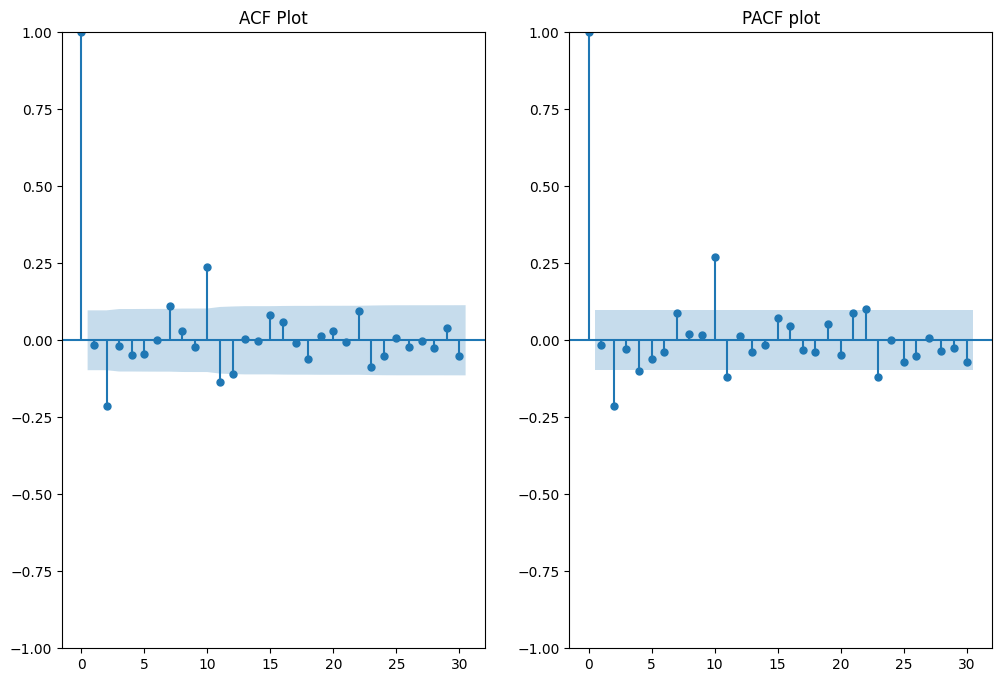

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff = df['retail'].diff().dropna()

fig, ax = plt.subplots(1,2, figsize=(12,8))
plot_acf(diff, ax[0], lags=30)
plot_pacf(diff, ax[1], lags=30)
ax[0].set_title('ACF Plot')
ax[1].set_title('PACF plot')
plt.show()



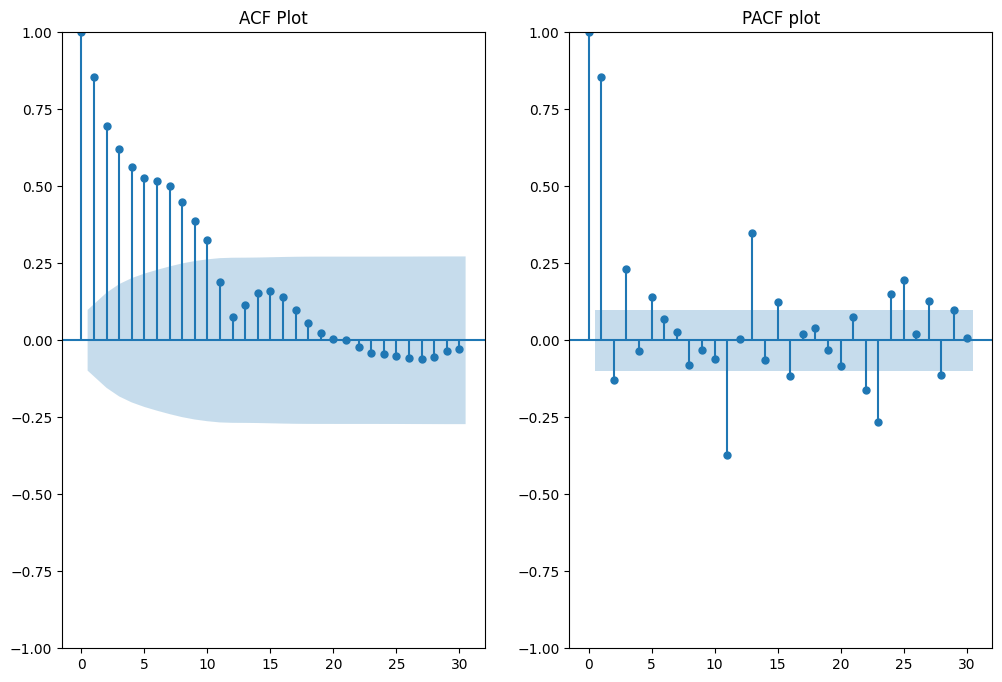

In [28]:
diff = df['retail'].diff(12).dropna()

fig, ax = plt.subplots(1,2, figsize=(12,8))
plot_acf(diff, ax[0], lags=30)
plot_pacf(diff, ax[1], lags=30)
ax[0].set_title('ACF Plot')
ax[1].set_title('PACF plot')
plt.show()

## No Stationarity - ARMA wont handle use ARIMA
## There is stationality - ARIMA wont handle it use SARIMA


# ARIMA - (p,d,q), SARIMA  - (P, D, Q)(p, d, q)

In [30]:
from statsmodels.tsa.arima.model import ARIMA

p,d,q = 1,1,1

model = ARIMA(df['retail'], order=(p,d,q))
fit = model.fit()
fit.summary()

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 retail   No. Observations:                  408
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4224.365
Date:                Fri, 20 Feb 2026   AIC                           8454.729
Time:                        16:06:47   BIC                           8466.756
Sample:                    01-01-1992   HQIC                          8459.488
                         - 12-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6228      0.242     -2.575      0.010      -1.097      -0.149
ma.L1          0.6708      0.243      2.758      0.006       0.194       1.148
sigma2      6.154e+07   4.33e-08   1.42e+15      0.000    6.15e+07    6.15e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):             44033.75
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              17.47   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.97e+30. Standard errors may be unstable.
"""

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p,d,q = 1,1,1
P,D,Q = 1,1,1

s_model = SARIMAX(
    df['retail'],
    order=(p,d,q),
    seasonal_order=(P,D,Q, 12),
    enforce_invertibility=False,
    enforce_stationarity=False
).fit()
s_model.summary()

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91639D+00    |proj g|=  3.65051D-01

At iterate    5    f=  9.89400D+00    |proj g|=  4.51159D-03

At iterate   10    f=  9.89334D+00    |proj g|=  3.34572D-02

At iterate   15    f=  9.89073D+00    |proj g|=  7.48501D-03

At iterate   20    f=  9.89063D+00    |proj g|=  3.05400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   3.054D-05   9.891D+00
  F =   9.8906268255738965     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             retail   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4035.376
Date:                            Fri, 20 Feb 2026   AIC                           8080.751
Time:                                    16:12:55   BIC                           8100.465
Sample:                                01-01-1992   HQIC                          8088.573
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5319      0.242     -2.201      0.028      -1.006      -0.058
ma.L1          0.6288      0.243      2.584      0.010       0.152       1.106
ar.S.L12      -0.2180      0.043     -5.126      0.000      -0.301      -0.135
ma.S.L12      -0.5285      0.032    -16.682      0.000      -0.591      -0.466
sigma2      1.354e+08   9.92e-09   1.36e+16      0.000    1.35e+08    1.35e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.39   Jarque-Bera (JB):             14083.70
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               7.47   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+31. Standard errors may be unstable.
"""

ARIMA

SARIMAX (X - exogenous variables)

In [32]:
exog = df['cpi'].astype(float)
exog = exog.ffill().bfill()

p,d,q = 1,1,1
P,D,Q = 1,1,1

s_model_exog = SARIMAX(
    df['retail'],
    order=(p,d,q),
    seasonal_order=(P,D,Q, 12),
    exog=exog,
    enforce_invertibility=False,
    enforce_stationarity=False
).fit()

s_model_exog.summary()

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03492D+01    |proj g|=  4.23153D+00

At iterate    5    f=  9.88087D+00    |proj g|=  1.28826D-02

At iterate   10    f=  9.87515D+00    |proj g|=  5.52585D-02

At iterate   15    f=  9.87201D+00    |proj g|=  2.35014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   5.836D-05   9.872D+00
  F =   9.8720107691250174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             retail   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4027.780
Date:                            Fri, 20 Feb 2026   AIC                           8067.561
Time:                                    16:20:37   BIC                           8091.218
Sample:                                01-01-1992   HQIC                          8076.947
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cpi         4193.7918    440.887      9.512      0.000    3329.669    5057.915
ar.L1          0.5105      0.121      4.218      0.000       0.273       0.748
ma.L1         -0.6567      0.112     -5.851      0.000      -0.877      -0.437
ar.S.L12      -0.3655      0.033    -10.934      0.000      -0.431      -0.300
ma.S.L12      -0.2178      0.033     -6.503      0.000      -0.283      -0.152
sigma2      1.215e+08      0.018   6.89e+09      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):              7802.77
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               9.23   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.74e+24. Standard errors may be unstable.
"""

In [38]:
df.index[-1]

Timestamp('2025-12-01 00:00:00')

In [34]:
future_index = pd.date_range(
    start= df.index[-1] + pd.offsets.MonthEnd(),
    periods=24,
    freq='ME'
)

future_exog = pd.Series(
    [exog.iloc[-1]] * 24,
    index=future_index
)

sarimax_future_fc = s_model_exog.forecast(24, exog=future_exog)

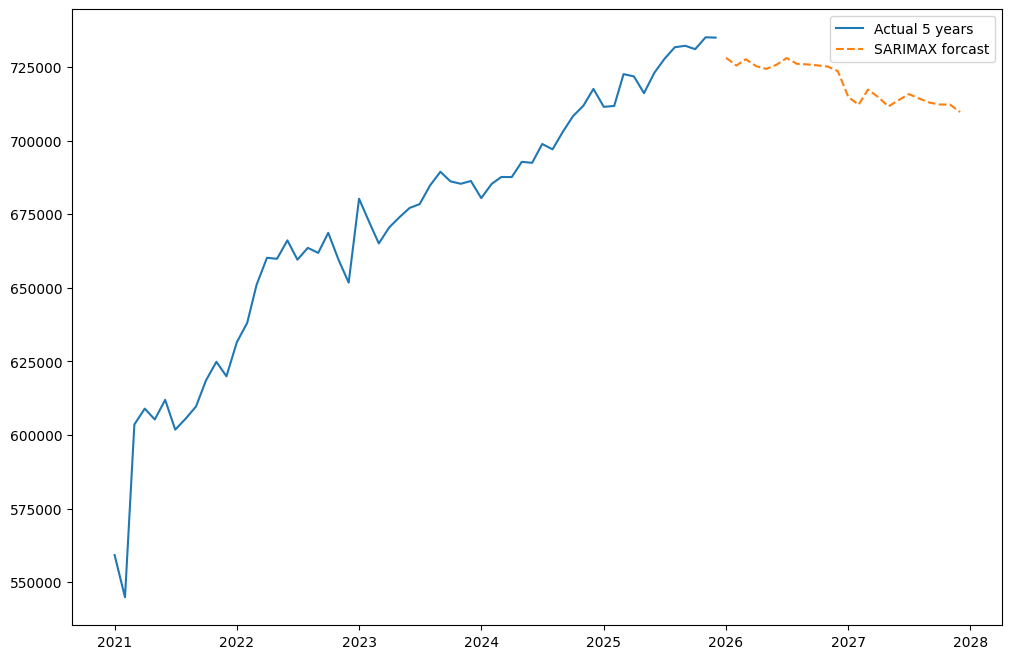

In [40]:
plt.figure(figsize=(12,8))

plt.plot(df['retail'].iloc[-60:], label= "Actual 5 years")
plt.plot(sarimax_future_fc, '--', label = "SARIMAX forcast")
plt.legend()
plt.show()

In [41]:
h = 24
train = df['retail'][:-h]
test = df['retail'][-h:]

In [42]:
arima_fit = ARIMA(train, order=(p, d, q)).fit()

arima_fc_test = arima_fit.forecast(h)

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [47]:
sarima_fit = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit()
sarima_fc_test = sarima_fit.forecast(h)

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02656D+01    |proj g|=  1.74796D-01

At iterate    5    f=  1.02441D+01    |proj g|=  1.09191D-02

At iterate   10    f=  1.02416D+01    |proj g|=  6.29226D-03

At iterate   15    f=  1.02409D+01    |proj g|=  3.75513D-03

At iterate   20    f=  1.02409D+01    |proj g|=  7.72792D-05

At iterate   25    f=  1.02408D+01    |proj g|=  8.90076D-03

At iterate   30    f=  1.02320D+01    |proj g|=  8.68831D-02

At iterate   35    f=  1.01901D+01    |proj g|=  7.69608D-03

At iterate   40    f=  1.01869D+01    |proj g|=  2.81483D-03

At iterate   45    f=  1.01869D+01    |proj g|=  4.18886D-04

At iterate   50    f=  1.01868D+01    |proj g|=  7.87801D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
exog_train = exog[:-h]
exog_test = exog[-h:]

sarimax_fit = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,12), exog=exog_train).fit()
sarimax_fc_test = sarimax_fit.forecast(h, exog=exog_test)

/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/Projects/itc/week_03/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06803D+01    |proj g|=  1.41972D+00


 This problem is unconstrained.



At iterate    5    f=  1.02811D+01    |proj g|=  1.20481D-02

At iterate   10    f=  1.02798D+01    |proj g|=  2.50492D-02

At iterate   15    f=  1.02796D+01    |proj g|=  3.97764D-03

At iterate   20    f=  1.02788D+01    |proj g|=  2.05162D-02

At iterate   25    f=  1.02778D+01    |proj g|=  3.22030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   2.827D-05   1.028D+01
  F =   10.277810413074510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def mape_custom(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


results = pd.DataFrame({
    'MAE': [
        mean_absolute_error(test, arima_fc_test),
        mean_absolute_error(test, sarima_fc_test),
        mean_absolute_error(test, sarimax_fc_test)
    ],
    'MAPE': [
        mape_custom(test, arima_fc_test),
       mape_custom(test, sarima_fc_test),
        mape_custom(test, sarimax_fc_test)
    ],
    'RMSE': [
        root_mean_squared_error(test, arima_fc_test),
        root_mean_squared_error(test, sarima_fc_test),
        root_mean_squared_error(test, sarimax_fc_test)
    ]
}, index = ['ARIMA', 'SARIMA', 'SARIMAX'])

results.head()

,MAE,MAPE,RMSE
ARIMA,25223.237944,3.495745,29962.911444
SARIMA,6020.505481,0.858536,7254.829203
SARIMAX,9587.657319,1.361291,11152.691460


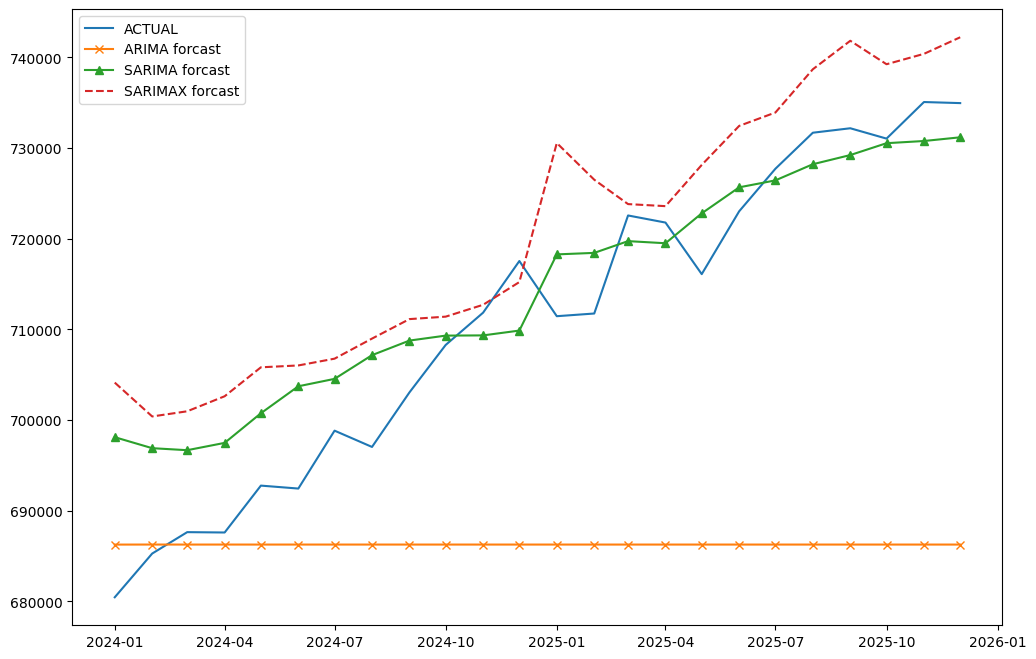

In [54]:
plt.figure(figsize=(12,8))
plt.plot(test.index, test.values, label = 'ACTUAL', )
plt.plot(test.index, arima_fc_test.values, 'x-', label= 'ARIMA forcast')
plt.plot(test.index, sarima_fc_test.values, '^-', label= 'SARIMA forcast')
plt.plot(test.index, sarimax_fc_test.values, '--', label= 'SARIMAX forcast')
plt.legend()
plt.show()